In [1]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/640px-Grosser_Panda.JPG

--2025-10-28 08:59:51--  https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/640px-Grosser_Panda.JPG
Translacja upload.wikimedia.org (upload.wikimedia.org)... 2a02:ec80:300:ed1a::2:b, 185.15.59.240
Łączenie się z upload.wikimedia.org (upload.wikimedia.org)|2a02:ec80:300:ed1a::2:b|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 96217 (94K) [image/jpeg]
Zapis do: ‘640px-Grosser_Panda.JPG’

640px-Grosser_Panda 100%[===================>]  93,96K   455KB/s    w 0,2s     

2025-10-28 08:59:51 (455 KB/s) - zapisano ‘640px-Grosser_Panda.JPG’ [96217/96217]



In [3]:
!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json

--2025-10-28 09:01:42--  https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
Translacja s3.amazonaws.com (s3.amazonaws.com)... 52.217.235.80, 52.217.126.176, 16.15.181.99, ...
Łączenie się z s3.amazonaws.com (s3.amazonaws.com)|52.217.235.80|:443... połączono.
Żądanie HTTP wysłano, oczekiwanie na odpowiedź... 200 OK
Długość: 35363 (35K) [application/octet-stream]
Zapis do: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34,53K  --.-KB/s    w 0,1s     

2025-10-28 09:01:43 (299 KB/s) - zapisano ‘imagenet_class_index.json’ [35363/35363]



In [5]:
import torch
import torch.nn as nn
import torchvision.transforms as T 
import matplotlib.pyplot as plt
from PIL import Image

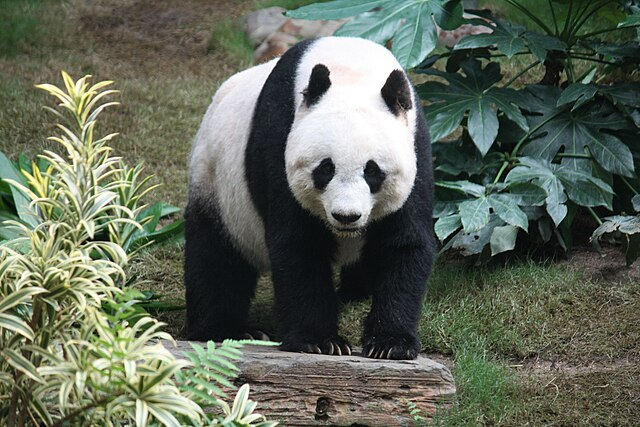

In [6]:
image_path = "./640px-Grosser_Panda.JPG"
image = Image.open(image_path)
image

In [7]:
torch_original = T.ToTensor()(image)
torch_original = T.Resize([480, 640])(torch_original)

In [9]:
from transformers import ConvNextForImageClassification

In [12]:
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-base-384-22k-1k", cache_dir="./cache/")


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/354M [00:00<?, ?B/s]

In [13]:
def normalize(x, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    n_channels = len(mean)
    mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
    std = torch.tensor(std).reshape(1, n_channels, 1, 1)
    return (x - mean)/std

In [15]:
torch_original.shape

torch.Size([3, 480, 640])

In [18]:
result = model(torch_original.unsqueeze(0)).logits

In [19]:
result.shape

torch.Size([1, 1000])

In [23]:
torch.argmax(result).item()

388

In [26]:
import json
dataset_indexes = json.load(open("./imagenet_class_index.json"))

In [27]:
dataset_indexes[str(388)]

['n02510455', 'giant_panda']

In [28]:
dataset_indexes[str(368)]

['n02483362', 'gibbon']

In [33]:
ground_truth_id = 388
target_id = 368

In [34]:
device = "cpu"

In [35]:
images = torch_original.unsqueeze(0)
labels = torch.tensor([ground_truth_id])

images = images.clone().detach().to(device)
labels = labels.clone().detach().to(device)

target_labels = torch.tensor([target_id])
target = torch.zeros(1000)
target[target_id] = 1
target = target.reshape(1,1000)

In [37]:
loss = nn.CrossEntropyLoss()
adv_images = images.clone().detach()
steps = 3
eps = 4/255
alpha = 1/255
# Starting at a uniformly random point
adv_images = adv_images + torch.empty_like(adv_images).uniform_(
    -eps, eps
)
adv_images = torch.clamp(adv_images, min=0, max=1).detach()
for _ in range(steps):
    adv_images.requires_grad = True
    x = normalize(adv_images)
    outputs = model(x).logits

    cost = -loss(outputs, target)
    grad = torch.autograd.grad(
        cost, adv_images, retain_graph=False, create_graph=False
    )[0]
    adv_images = adv_images.detach() + alpha * grad.sign()
    delta = torch.clamp(adv_images - images, min=-eps, max=eps)
    adv_images = torch.clamp(images + delta, min=0, max=1).detach()
    

In [38]:
logits = model(adv_images).logits
prediction = torch.argmax(logits).item()
message = "CORRECT! Model was pwnd." if target_id==prediction else "Wrong!"
print(f"{message} target:{target_id}, prediction:{prediction}, ground_truth_id was:{ground_truth_id}")

CORRECT! Model was pwnd. target:368, prediction:368, ground_truth_id was:388


In [39]:
prediction

368

Text(0.5, 1.0, "Class: ['n02510455', 'giant_panda']")

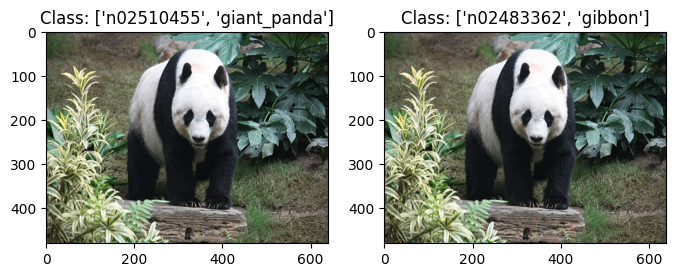

In [46]:
base_prediction = 388
fig, axe = plt.subplots(1,2, figsize = (8,6))
class_name = dataset_indexes[str(base_prediction)]

crafted_image = adv_images[0].detach().permute(1,2,0).cpu().numpy()
original_image = torch_original.detach().permute(1,2,0).cpu().numpy()
axe[1].imshow(crafted_image)
crafted_class_name = dataset_indexes[str(prediction)]
axe[1].set_title(f"Class: {crafted_class_name}")
axe[0].imshow(original_image)
axe[0].set_title(f"Class: {class_name}")